# Model

This model is build to work with data from multiple datasets that have been processed to 112x112 size.

## Imports and information

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Sequence
from functools import partial
from random import randint

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torchmetrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
# MLFW data paths
mlfw_X_fp = r'D:\data\face_mask\MLFW\MLFW_X.npy'
mlfw_y_fp = r'D:\data\face_mask\MLFW\MLFW_y.npy'

## WWMR data paths
wwmr_X_fp = r'D:\data\face_mask\WWMR cropped MediaPipe\WWMR_X_for_model.npy'
wwmr_y_fp = r'D:\data\face_mask\WWMR cropped MediaPipe\WWMR_y_for_model.npy'

# fmd_12k data paths
fmd12k_X_fp = r'D:\data\face_mask\FaceMaskDetection_12k\Cropped\images.npy'
fmd12k_y_fp = r'D:\data\face_mask\FaceMaskDetection_12k\Cropped\labels.npy'

## Build data loader

In [5]:
class maskDataset(Dataset):
    def __init__(
        self,
        X_data,
        y_data,
        norm_0_1: bool = True,
        print_stats: bool = True,
    ):        
        self.X_data = X_data
        
        # Norm
        if norm_0_1:
            self.X = self.X_data / 255
        else:
            self.X = self.X_data
        
        self.y = y_data
        
        self.length = len(self.y)
        
        # Print Stats
        if print_stats:
            print('# examples:    {}'.format(self.length))
            ratio = sum(self.y) / self.length
            print('class balence: {:.2f}'.format(ratio))

        # reshape?? see comment in __getitem__() ?????
        self.X = self.X.reshape((self.length, 3, 112, 112)) 
        
    def __len__(self):
        return self.length
    
   
    def __getitem__(self, index):
        image = self.X[index]
        
        # the input to a conv2d must be in [N, C, W, H] format
        #  n = number of examples, c is channels, w is width, and h is height
        #  This means we do not in fact need to transpose the data. it should
        #  be in the shape (3, 112, 112)
        #image = np.transpose(image)
        #image = np.rot90(image, k=3)
        
        return image.astype(np.float32), torch.tensor(self.y[index]).long()    

In [6]:
# function to concat the various data sets and split into train val test

def merge_split(
    X_data_lists: list,
    y_data_lists: list,
    train=0.7,
    val=0.15,
    test=0.15
):
    if (train + val + test) != 1:
        print('splits must add to 1, added to {}'.format(train + val + test))
        return None
    if train < 0 or val < 0 or test < 0:
        print('splits must be positive')
        return None

    # Concat
    X = np.concatenate(X_data_lists)
    y = np.concatenate(y_data_lists)
    
    # split off test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test, random_state=42)
    
    # split off val
    val_percent_tv = val / (val + train)  # 15 percent of total data is equal to this
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_percent_tv, random_state=42)
    
    return [(X_train, y_train), (X_val, y_val), (X_test, y_test)]

### Test data loader

In [7]:
# data file paths
X_fp_list = [mlfw_X_fp, wwmr_X_fp, fmd12k_X_fp]
y_fp_list = [mlfw_y_fp, wwmr_y_fp, fmd12k_y_fp]

X_data_list = [np.load(fp) for fp in X_fp_list]
y_data_list = [np.load(fp) for fp in y_fp_list]

In [8]:
# merge data and split into train val and test
(X_train, y_train), (X_val, y_val), (X_test, y_test) = merge_split(X_data_list, y_data_list)

In [9]:
ds = maskDataset(
    X_data=X_train,
    y_data=y_train,
    norm_0_1=True,
    print_stats=True,
)

# examples:    15078
class balence: 0.56


In [10]:
ds.X.shape

(15078, 3, 112, 112)

In [11]:
ds[2][0].shape

(3, 112, 112)

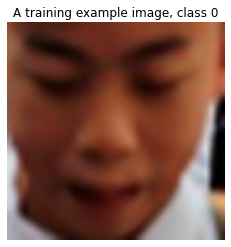

In [12]:
img_idx = randint(0, 8791)

image, label = ds[img_idx]

# un-normalize
image = (image * 255).astype(np.uint8)

# show image
plt.imshow(image.reshape(112, 112, 3))
plt.title('A training example image, class {}'.format(label) )
plt.axis('off')
plt.show()

## Model

The following model is implemented in pytorch. It uses several convotutional layers followed by several linear layers.

In [275]:
class CNN(nn.Module):
    def __init__(
        self,
        input_size: Sequence[int] = (3, 112, 112),
        num_classes: int = 2,
        channels: Sequence[int] = (8, 16, 32),
        kernel_sizes: Sequence[int] = (10, 10, 10),
        linear_units: Sequence[int] = (100, 10),
        lr: float = 0.001,
        epochs: int = 10
    ):
        super(CNN, self).__init__()
        
        self.input_size = input_size
        self.num_classes = num_classes
        self.channels = input_size[0:1] + channels
        self.kernel_sizes = kernel_sizes
        self.linear_units = linear_units
        self.lr = lr
        self.epochs = epochs
        
        self.flatten = nn.Flatten()
        self.pool = partial(nn.MaxPool2d, kernel_size=2, stride=1)  # first 2 is for 2x2 kernel, second arg is stride length
        self.pool2 = partial(nn.MaxPool2d, kernel_size=2, stride=2)  # first 2 is for 2x2 kernel, second arg is stride length
        self.dropout = nn.Dropout
        self.activation = nn.ReLU
        self.accuracy = torchmetrics.functional.accuracy
        self.conf_matrix = torchmetrics.functional.confusion_matrix
        
        # optional, define batch norm here
        
        # build the convolutional layers
        conv_layers = list()
        idx = 0
        for in_channels, out_channels, kernel_size in zip(
            self.channels[:-2], self.channels[1:-1], self.kernel_sizes[:-1]
        ):
            if idx == len(channels) - 2:
                conv_layers.append(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        stride=2,
                        #padding='same',
                    )
                )
            else:
                conv_layers.append(
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=kernel_size,
                        #stride=2,
                        #padding='same',
                    )
                )
            conv_layers.append(self.activation())
            conv_layers.append(self.pool())
            
            idx += 1
        
        # add final layer to convolutions
        conv_layers.append(
            nn.Conv2d(
                in_channels=self.channels[-2],
                out_channels=self.channels[-1],
                kernel_size=self.kernel_sizes[-1],
                stride=2,
                #padding='same',
            )
        )
        conv_layers.append(self.activation())
        conv_layers.append(self.pool2())

        
        # turn list into layers
        self.conv_net = nn.Sequential(*conv_layers)
        
        # calc lin layer input size
        temp = (self.input_size[2] - sum(kernel_sizes) )/ 4
        conv_out_size = int((temp + 1) / 2)
        lin_size = conv_out_size * conv_out_size * channels[-1]
        #print(lin_size)
        
        stride = [1] * len(self.kernel_sizes)
        stride[-1] = 2
        stride[-2] = 2
        #print(stride)
        curr = self.input_size[2]
        for i, k in enumerate(self.kernel_sizes):
            curr = curr - k
            curr = curr / stride[i]
            curr += 1
            #print(curr)
        curr = int(curr / 2)
        #print('new: {}'.format(curr))
        lin_size = curr * curr * channels[-1]
        
        # linear layers
        linear_layers = list()
        prev_linear_size = lin_size
        for dense_layer_size in self.linear_units:
            linear_layers.append(
                nn.Linear(
                    in_features=prev_linear_size,
                    out_features=dense_layer_size,
                )
            )
            linear_layers.append(self.activation())
            prev_linear_size=dense_layer_size
            
        self.penultimate_dense = nn.Sequential(*linear_layers)
        self.ultimate_dense = nn.Linear(
            in_features=self.linear_units[-1],
            out_features=self.num_classes
        )
    
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_net(x)
        #print(x.shape)
        x = self.flatten(x)
        # may need to expand dense entry since flatten
        x = self.penultimate_dense(x)
        x = self.ultimate_dense(x)
        return x


def train(dataloader, model, loss_fn, optimizer, verbose=False):
    #model = model.float()  # sometime fixes random obscure type error
    model.train()  # configures for training, grad on, dropout if there is dropout
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        
        # compute prediction loss
        preds = model(X)
        loss = loss_fn(preds, y)
        
        # backprop
        loss.backward()
        optimizer.step()
        
        if batch % 5 == 0 and verbose:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss

# for evaluating on validation data too
def test(dataloader, model, loss_fn, verbose=False):
    model.eval()
    test_loss, correct = 0, 0
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for X, y in dataloader:

            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Results: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss
        

The below 2 blocks show the structure of the model with the default parameters for the convolution sizes, convolution kernel sizes, and linear layer sizes.

In [276]:
model_display = CNN(
    channels=(8, 16, 24, 32),
    kernel_sizes=(10, 10, 10, 10),
    linear_units=(1000, 500, 100, 10),
)
model_display

CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_net): Sequential(
    (0): Conv2d(3, 8, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(10, 10), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 24, kernel_size=(10, 10), stride=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(24, 32, kernel_size=(10, 10), stride=(2, 2))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (penultimate_dense): Sequential(
    (0): Linear(in_features=2048, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    

In [277]:
X, y = train_dataset[0:2]
X.shape

(2, 3, 112, 112)

In [278]:
model_display.conv_net(torch.Tensor(X)).shape

torch.Size([2, 32, 8, 8])

In [279]:
model_display.conv_net(torch.Tensor(X)).shape

torch.Size([2, 32, 8, 8])

In [280]:
8 * 8 * 32

2048

In [281]:
model_display.input_size[2] - 50

62

In [282]:
model_display.forward(torch.Tensor(X))

tensor([[-0.1913,  0.2764],
        [-0.1912,  0.2763]], grad_fn=<AddmmBackward0>)

## Running the model

Running the pytorch model involves several steps. First, the pytorch datasets must be set up. They take in the X and y data at construction to become an object that can serve up the data on command. Next, the pytorch data loaders are created. These data loaders are another pytorch object which takes in the dataset, whether to shuffle or not, and the batch size.

The model, loss function, and optimizer are created next. The training loop follows. This loop runs the training loop defined above with the model and then evaluates on the validation data.

In [230]:
# Create datasets
train_dataset = maskDataset(
    X_data=X_train,
    y_data=y_train,
    norm_0_1=True,
    print_stats=False,
)

val_dataset = maskDataset(
    X_data=X_val,
    y_data=y_val,
    norm_0_1=True,
    print_stats=False,
)

test_dataset = maskDataset(
    X_data=X_test,
    y_data=y_test,
    norm_0_1=True,
    print_stats=False,
)

In [283]:
# Create the dataloaders
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Create CNN
model = CNN(
    channels=(8, 16, 20, 24, 24),
    kernel_sizes=(10, 10, 10, 12, 12),
    linear_units=(1000, 250, 10),
)



# use cross entropy loss
loss_fn = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=0.005,
    momentum=0.9,
    #nesterov =True
    weight_decay =.0001
)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# record results
train_loss = []
val_loss = []
val_accur = []

epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=True)
    train_loss.append(train_l)
    
    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=True)
    val_loss.append(val_l)
    val_accur.append(val_a) 

Using cpu device
Epoch 1
-------------------------------
loss: 0.737606  [    0/15078]
loss: 0.744497  [  640/15078]
loss: 0.750687  [ 1280/15078]
loss: 0.727971  [ 1920/15078]
loss: 0.694906  [ 2560/15078]
loss: 0.713736  [ 3200/15078]
loss: 0.702511  [ 3840/15078]
loss: 0.699192  [ 4480/15078]
loss: 0.693599  [ 5120/15078]
loss: 0.689570  [ 5760/15078]
loss: 0.688264  [ 6400/15078]
loss: 0.677754  [ 7040/15078]
loss: 0.685393  [ 7680/15078]
loss: 0.683217  [ 8320/15078]
loss: 0.671568  [ 8960/15078]
loss: 0.698884  [ 9600/15078]
loss: 0.688622  [10240/15078]
loss: 0.688817  [10880/15078]
loss: 0.675889  [11520/15078]
loss: 0.683100  [12160/15078]
loss: 0.680901  [12800/15078]
loss: 0.674691  [13440/15078]
loss: 0.687334  [14080/15078]
loss: 0.674543  [14720/15078]
Results: 
 Accuracy: 55.3%, Avg loss: 0.687457 

Epoch 2
-------------------------------
loss: 0.685103  [    0/15078]
loss: 0.682854  [  640/15078]
loss: 0.682868  [ 1280/15078]
loss: 0.678288  [ 1920/15078]
loss: 0.683017

loss: 0.264414  [ 1280/15078]
loss: 0.341650  [ 1920/15078]
loss: 0.257641  [ 2560/15078]
loss: 0.249503  [ 3200/15078]
loss: 0.205000  [ 3840/15078]
loss: 0.235511  [ 4480/15078]
loss: 0.162287  [ 5120/15078]
loss: 0.227625  [ 5760/15078]
loss: 0.233821  [ 6400/15078]
loss: 0.306066  [ 7040/15078]
loss: 0.334803  [ 7680/15078]
loss: 0.310557  [ 8320/15078]
loss: 0.256445  [ 8960/15078]
loss: 0.273013  [ 9600/15078]
loss: 0.326041  [10240/15078]
loss: 0.276011  [10880/15078]
loss: 0.201515  [11520/15078]
loss: 0.235076  [12160/15078]
loss: 0.283954  [12800/15078]
loss: 0.221669  [13440/15078]
loss: 0.169489  [14080/15078]
loss: 0.180030  [14720/15078]
Results: 
 Accuracy: 90.4%, Avg loss: 0.257077 

Epoch 12
-------------------------------
loss: 0.231052  [    0/15078]
loss: 0.238338  [  640/15078]
loss: 0.141971  [ 1280/15078]
loss: 0.238139  [ 1920/15078]
loss: 0.299030  [ 2560/15078]
loss: 0.222384  [ 3200/15078]
loss: 0.407773  [ 3840/15078]
loss: 0.304300  [ 4480/15078]
loss: 0.21

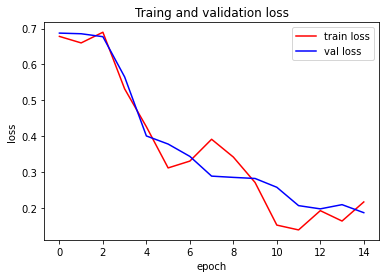

In [284]:
# plot training loss and validation loss
plt.plot(np.arange(len(train_loss)), [i.item() for i in train_loss], 'r', label='train loss') # train in red
plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='val loss')# val in blue
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Traing and validation loss')
plt.show()

In [285]:
# 5 more epochs

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=True)
    train_loss.append(train_l)
    
    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=True)
    val_loss.append(val_l)
    val_accur.append(val_a) 

Epoch 1
-------------------------------
loss: 0.215898  [    0/15078]
loss: 0.293785  [  640/15078]
loss: 0.201036  [ 1280/15078]
loss: 0.171557  [ 1920/15078]
loss: 0.145148  [ 2560/15078]
loss: 0.170801  [ 3200/15078]
loss: 0.262786  [ 3840/15078]
loss: 0.213447  [ 4480/15078]
loss: 0.179175  [ 5120/15078]
loss: 0.148568  [ 5760/15078]
loss: 0.202989  [ 6400/15078]
loss: 0.218207  [ 7040/15078]
loss: 0.203972  [ 7680/15078]
loss: 0.152598  [ 8320/15078]
loss: 0.186304  [ 8960/15078]
loss: 0.173801  [ 9600/15078]
loss: 0.123450  [10240/15078]
loss: 0.194701  [10880/15078]
loss: 0.264114  [11520/15078]
loss: 0.188916  [12160/15078]
loss: 0.260924  [12800/15078]
loss: 0.186690  [13440/15078]
loss: 0.147473  [14080/15078]
loss: 0.112222  [14720/15078]
Results: 
 Accuracy: 92.1%, Avg loss: 0.196190 

Epoch 2
-------------------------------
loss: 0.214472  [    0/15078]
loss: 0.162988  [  640/15078]
loss: 0.216132  [ 1280/15078]
loss: 0.135579  [ 1920/15078]
loss: 0.119976  [ 2560/15078]
l

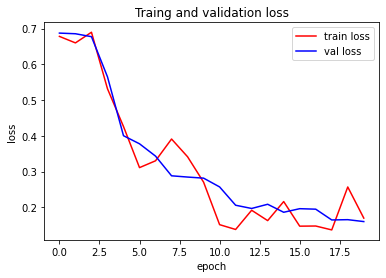

In [286]:
# plot training loss and validation loss
plt.plot(np.arange(len(train_loss)), [i.item() for i in train_loss], 'r', label='train loss') # train in red
plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='val loss')# val in blue
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Traing and validation loss')
plt.show()

In [ ]:
best_val_acc = 0

In [293]:
epoch_counter = 27

In [294]:
# more epochs, saving best val

weights_state_base_fp = r'./results/upgrade/full_model_upgrade_'
optimizer_state_base_fp = r'./results/upgrade/full_optimizer_upgrade_'


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=True)
    train_loss.append(train_l)
    
    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=True)
    val_loss.append(val_l)
    val_accur.append(val_a) 
    
    epoch_counter += 1
    
    if val_a > best_val_acc:
        best_val_acc = val_a
        out_fp = weights_state_base_fp + str(epoch_counter)
        torch.save(model.state_dict(), out_fp)
        optim_fp = optimizer_state_base_fp + str(epoch_counter)
        torch.save(optimizer.state_dict(), optim_fp)

Epoch 1
-------------------------------
loss: 0.180649  [    0/15078]
loss: 0.098230  [  640/15078]
loss: 0.121553  [ 1280/15078]
loss: 0.086369  [ 1920/15078]
loss: 0.140690  [ 2560/15078]
loss: 0.167311  [ 3200/15078]
loss: 0.083937  [ 3840/15078]
loss: 0.123111  [ 4480/15078]
loss: 0.131189  [ 5120/15078]
loss: 0.103990  [ 5760/15078]
loss: 0.117956  [ 6400/15078]
loss: 0.199627  [ 7040/15078]
loss: 0.093161  [ 7680/15078]
loss: 0.116982  [ 8320/15078]
loss: 0.119668  [ 8960/15078]
loss: 0.148468  [ 9600/15078]
loss: 0.196880  [10240/15078]
loss: 0.228657  [10880/15078]
loss: 0.083997  [11520/15078]
loss: 0.134714  [12160/15078]
loss: 0.128567  [12800/15078]
loss: 0.161533  [13440/15078]
loss: 0.103664  [14080/15078]
loss: 0.075026  [14720/15078]
Results: 
 Accuracy: 94.9%, Avg loss: 0.137986 

Epoch 2
-------------------------------
loss: 0.121880  [    0/15078]
loss: 0.065191  [  640/15078]
loss: 0.142476  [ 1280/15078]
loss: 0.226767  [ 1920/15078]
loss: 0.147818  [ 2560/15078]
l

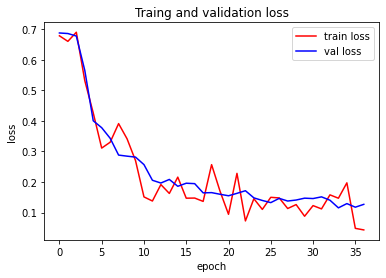

In [295]:
# plot training loss and validation loss
plt.plot(np.arange(len(train_loss)), [i.item() for i in train_loss], 'r', label='train loss') # train in red
plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='val loss')# val in blue
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Traing and validation loss')
plt.show()

Since the validation loss continues to improve, the training will continue.

In [296]:
# more epochs, saving best val

weights_state_base_fp = r'./results/upgrade/full_model_upgrade_'
optimizer_state_base_fp = r'./results/upgrade/full_optimizer_upgrade_'


epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=True)
    train_loss.append(train_l)
    
    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=True)
    val_loss.append(val_l)
    val_accur.append(val_a) 
    
    epoch_counter += 1
    
    if val_a > best_val_acc:
        best_val_acc = val_a
        print('new best val acc of {} at {}'.format(best_val_acc, epoch_counter))
        out_fp = weights_state_base_fp + str(epoch_counter)
        torch.save(model.state_dict(), out_fp)
        optim_fp = optimizer_state_base_fp + str(epoch_counter)
        torch.save(optimizer.state_dict(), optim_fp)

Epoch 1
-------------------------------
loss: 0.048315  [    0/15078]
loss: 0.101188  [  640/15078]
loss: 0.087509  [ 1280/15078]
loss: 0.064532  [ 1920/15078]
loss: 0.055311  [ 2560/15078]
loss: 0.105524  [ 3200/15078]
loss: 0.058189  [ 3840/15078]
loss: 0.068133  [ 4480/15078]
loss: 0.129250  [ 5120/15078]
loss: 0.151189  [ 5760/15078]
loss: 0.080917  [ 6400/15078]
loss: 0.091961  [ 7040/15078]
loss: 0.087784  [ 7680/15078]
loss: 0.050792  [ 8320/15078]
loss: 0.048568  [ 8960/15078]
loss: 0.090291  [ 9600/15078]
loss: 0.116269  [10240/15078]
loss: 0.045887  [10880/15078]
loss: 0.066923  [11520/15078]
loss: 0.158926  [12160/15078]
loss: 0.126868  [12800/15078]
loss: 0.114654  [13440/15078]
loss: 0.139294  [14080/15078]
loss: 0.206911  [14720/15078]
Results: 
 Accuracy: 94.6%, Avg loss: 0.154291 

Epoch 2
-------------------------------
loss: 0.089915  [    0/15078]
loss: 0.062476  [  640/15078]
loss: 0.075853  [ 1280/15078]
loss: 0.084240  [ 1920/15078]
loss: 0.088036  [ 2560/15078]
l

loss: 0.026685  [    0/15078]
loss: 0.015421  [  640/15078]
loss: 0.029668  [ 1280/15078]
loss: 0.015718  [ 1920/15078]
loss: 0.031593  [ 2560/15078]
loss: 0.066105  [ 3200/15078]
loss: 0.053149  [ 3840/15078]
loss: 0.061841  [ 4480/15078]
loss: 0.067080  [ 5120/15078]
loss: 0.050388  [ 5760/15078]
loss: 0.031266  [ 6400/15078]
loss: 0.013416  [ 7040/15078]
loss: 0.032130  [ 7680/15078]
loss: 0.030170  [ 8320/15078]
loss: 0.022381  [ 8960/15078]
loss: 0.053913  [ 9600/15078]
loss: 0.031240  [10240/15078]
loss: 0.030134  [10880/15078]
loss: 0.024967  [11520/15078]
loss: 0.031484  [12160/15078]
loss: 0.010217  [12800/15078]
loss: 0.037803  [13440/15078]
loss: 0.068215  [14080/15078]
loss: 0.028727  [14720/15078]
Results: 
 Accuracy: 94.9%, Avg loss: 0.149412 

Epoch 12
-------------------------------
loss: 0.079077  [    0/15078]
loss: 0.041711  [  640/15078]
loss: 0.082131  [ 1280/15078]
loss: 0.013174  [ 1920/15078]
loss: 0.021233  [ 2560/15078]
loss: 0.006386  [ 3200/15078]
loss: 0.03

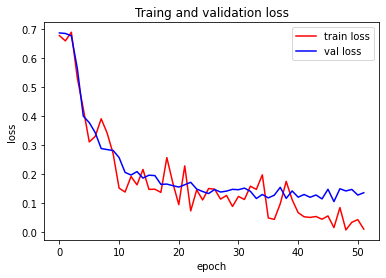

In [297]:
# plot training loss and validation loss
plt.plot(np.arange(len(train_loss)), [i.item() for i in train_loss], 'r', label='train loss') # train in red
plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='val loss')# val in blue
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Traing and validation loss')
plt.show()

We see validation loss plateau, and training loss diverge from validation loss around epoch 40. We get our best validation loss and accuracy at epoch 47. Shortly afterwards, validation loss starts to actually climb, a definite sign of overfitting.

In [307]:
best_model = CNN(
    channels=(8, 16, 20, 24, 24),
    kernel_sizes=(10, 10, 10, 12, 12),
    linear_units=(1000, 250, 10),
)

best_weights_fp = r'C:\Users\Andrew\Documents\2022 Summer\Data Mining\Project\results\upgrade\full_model_upgrade_47'
best_model.load_state_dict(torch.load(best_weights_fp))

<All keys matched successfully>

In [308]:
# get val predictions and true labels for a classification report
preds = []
y_true = []

best_model.eval()
with torch.no_grad():
    for X, y in val_dataloader:
        pred = best_model(X.float())
        preds.append(pred)
        y_true.append(y)

y_pred = np.concatenate(preds).argmax(1)
y_true = np.concatenate(y_true)

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1444
           1       0.98      0.97      0.97      1788

    accuracy                           0.97      3232
   macro avg       0.97      0.97      0.97      3232
weighted avg       0.97      0.97      0.97      3232



In [309]:
# Save FULL model
# different than just weights
# https://pytorch.org/tutorials/beginner/saving_loading_models.html

# model out path
#model_out_path = r'C:\Users\Andrew\Documents\2022 Summer\Data Mining\Project\results\upgrade\full_model_best'
#torch.save(best_model, model_out_path)


With the current parameters, we get an accuracy of 97% on the validation data and an f1 score of 0.97.

### Optimizer param sweep

This is only viable for really quickly trained models. The current model took over a day to train and scored high accuracy, so this parameter sweep does not meet a cost/benefit threshold.

In [298]:
"""
# Create the dataloaders
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

lrs = [.005, .01]
decays = [.0001, .0005]
channels = [(16, 24, 32), (8, 16, 32), (8, 16, 24, 32)] 
linear_units = [ (100, 10), (100, 50, 10)]

lr_list = []
deacy_list = []
max_val_acc_list = []
at_epoch_list = []
channel_list = []
linear_units_list = []

counter = 0
num_runs = len(lrs) * len(decays) * len(channels) * len(linear_units)

for lr in lrs:
    for decay in decays:
        for channel in channels:
            for linear_unit in linear_units:

                max_val_acc = 0
                best_epoch = 0

                # Create CNN
                model = CNN(
                    channels=channel,
                    #kernel_sizes=kernel_size,
                    linear_units=linear_unit,
                )

                # use cross entropy loss
                loss_fn = nn.CrossEntropyLoss()

                # SGD optimizer
                optimizer = torch.optim.SGD(
                    model.parameters(), 
                    lr=lr,
                    momentum=0.9,
                    #nesterov =True
                    weight_decay=decay
                )
                #optimizer = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


                # record results
                train_loss = []
                val_loss = []
                val_accur = []

                epochs = 25
                for t in range(epochs):
                    #print(f"Epoch {t+1}\n-------------------------------")

                    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
                    train_loss.append(train_l)

                    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=False)
                    val_loss.append(val_l)
                    val_accur.append(val_a) 

                    if val_a > max_val_acc:
                        max_val_acc = val_a
                        best_epoch = t


                lr_list.append(lr)
                deacy_list.append(decay)
                max_val_acc_list.append(max_val_acc)
                at_epoch_list.append(best_epoch)
                channel_list.append(channel)
                linear_units_list.append(linear_unit)
                
                counter += 1
                print('finished {} of {}'.format(counter, num_runs))
            print('finished linear unit {}'.format(linear_unit))
        print('finished channels set')
    print('finished lr {}'.format(lr))

"""
print()

In [299]:
"""
results = pd.DataFrame(
    data={
        'lr': lr_list,
        'decay': deacy_list,
        'val acc': max_val_acc_list,
        'at epoch': at_epoch_list,
        'channels': channel_list,
        'linear units': linear_units_list
    }
)
"""
print()

In [300]:
#results

In [301]:
#results.sort_values(by='val acc', ascending=False)

In [302]:
#results.to_pickle('./results/default_model_full_hyperparam_results.pickle')

In [303]:
# load results
#results_from_file = pd.read_pickle('./results/default_model_full_hyperparam_results.pickle')
#sorted_results = results_from_file.sort_values(by='val acc', ascending=False)
#sorted_results.head(7)

This sweep tells us that a lr of .010 and a decay of .0001 gives the best validation accuracy of 98% at epoch 23. The channels are 8, 16, 32 and the linear units are 100, 10.

### Training an optimized model

In [304]:
## Since no parameter sweep, the current model is the best model so far.

"""
# Create the dataloaders
batch_size = 128

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



max_val_acc = 0
best_epoch = 0

# Create CNN Model
model = CNN(
    channels = (8, 16, 32),
    #kernel_sizes = (10, 10, 10, 10),
    linear_units = (100, 10),
)

# use cross entropy loss
loss_fn = nn.CrossEntropyLoss()

# SGD optimizer
optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=.010,
    momentum=0.9,
    #nesterov =True
    weight_decay=.0001
)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


# record results
train_loss = []
val_loss = []
val_accur = []


epochs = 23
for t in range(epochs):
    #print(f"Epoch {t+1}\n-------------------------------")

    train_l = train(train_dataloader, model, loss_fn, optimizer, verbose=False)
    train_loss.append(train_l)

    val_a, val_l = test(val_dataloader, model, loss_fn, verbose=False)
    val_loss.append(val_l)
    val_accur.append(val_a) 

    if val_a > max_val_acc:
        max_val_acc = val_a
        best_epoch = t
"""
print()

In [305]:
# plot training loss and validation loss

#plt.plot(np.arange(len(train_loss)), [i.item() for i in train_loss], 'r', label='train loss') # train in red
#plt.plot(np.arange(len(val_loss)), val_loss, 'b', label='val loss')# val in blue
#plt.xlabel('epoch')
#plt.ylabel('loss')
#plt.legend()
#plt.title('Traing and validation loss for 1 hidden layer size 64')
#plt.show()

### Performance on Test Data

In [310]:
# get val predictions and true labels for a classification report on Test Data

preds = []
y_true = []

best_model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        pred = best_model(X.float())
        preds.append(pred)
        y_true.append(y)

y_pred = np.concatenate(preds).argmax(1)
y_true = np.concatenate(y_true)

report = classification_report(y_true=y_true, y_pred=y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1404
           1       0.96      0.95      0.96      1828

    accuracy                           0.95      3232
   macro avg       0.95      0.95      0.95      3232
weighted avg       0.95      0.95      0.95      3232



In [311]:
val_a, val_l = test(test_dataloader, best_model, loss_fn, verbose=False)
print('Test accuracy: {:.2%}'.format(val_a))

Test accuracy: 95.17%


The variance in this value is due to the stochastic nature of pytorch in how I've implemented the model. This result deviated from results in the sweep by just a little, which is no cause for alarm.


### Saving the model weights

To reuse the model, we will save the weights. Pytorch offers a very easy way to save model weights. The model itself will be placed into a python file so it can be imported.

In [40]:
#  CHANGE NAME TO NOT OVERWRITE
#weights_fp = './results/torch_full_model_weights2'
#torch.save(model.state_dict(), weights_fp)